# Lunch and Learn Notebook

In [8]:
# Import necessary libraries
from pathlib import Path
from fw_dataset_nlq_extension import NLDataset
import logging
from dotenv import load_dotenv
from IPython.display import Image, display

# the "env" file must have `OPENAI_API_KEY="the key"`
load_dotenv("env")
logging.basicConfig(level=logging.WARNING)

## Sample Dataset

The 1158 patient dataset is created from the [Synthea Patient Generator](https://github.com/synthetichealth/synthea). 

Synthea is a Synthetic Patient Population Simulator. The goal is to output synthetic, realistic (but not real), patient data and associated health records in a variety of formats.

Some attributes of the dataset include integrations with [Flywheel](https://flywheel.io/) concepts.

In [9]:
# Define dataset location and credentials
fs_type = 'local'
bucket = Path("/home/josher/fw_data/datasets/")
prefix = Path("latest.sse.flywheel.io/joshuajacobs/66e9944c147d489c6d5def50")
credentials = None
dataset = NLDataset.get_dataset_from_filesystem(fs_type, bucket, prefix, credentials)

# Set logging level and verbosity
dataset.set_logging_level(logging.INFO)
dataset.verbose = True
dataset.display = True
# Connect to the Dataset
dataset.connect()

## Sample SQL Queries

In [10]:
# Interrogate Tables Available in the Dataset

dataset.execute("SHOW TABLES;").df()

,name
0,RAG_table
1,acquisitions
2,allergies
3,analyses
4,careplans
5,claims
6,claims_transactions
7,conditions
8,devices
9,encounters


In [11]:
# Display a Sample of the procedures Table

dataset.execute("SELECT START, STOP, PATIENT, ENCOUNTER, SYSTEM, CODE, DESCRIPTION, BASE_COST, REASONCODE, REASONDESCRIPTION FROM procedures LIMIT 3;").df()

,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
0,2016-01-22T15:21:48Z,2016-01-22T16:21:42Z,2794f0b0-bc4d-543f-902c-099f7e425c22,25e9b4da-9c37-1daf-761f-040501215d72,http://snomed.info/sct,65200003,Insertion of intrauterine contraceptive device,15641.36,NaN,
1,2016-05-30T21:21:48Z,2016-05-30T21:36:48Z,2794f0b0-bc4d-543f-902c-099f7e425c22,7dc05f41-6a66-a082-dd2c-b25402946c06,http://snomed.info/sct,430193006,Medication Reconciliation (procedure),294.18,NaN,
2,2016-05-30T21:21:48Z,2016-05-30T21:57:38Z,2794f0b0-bc4d-543f-902c-099f7e425c22,7dc05f41-6a66-a082-dd2c-b25402946c06,http://snomed.info/sct,710824005,Assessment of health and social care needs (pr...,431.40,NaN,


## Using Natural Language to Query a Database

The Natural Language Dataset extension has the following two public functions:

- `dataset.semantic_search()` 
  - Performs a semantic search on an established RAG table and returns a list of results.
- `dataset.nl_query()` 
  - Performs a Natural Language Query on the dataset and returns a result based on context.

### Using a Semantic Search

In [12]:
# Ask a question not relevant to the dataset
dataset.semantic_search("What is the meaning of life?")

'This question is not relevant to the database or its use. It pertains to philosophical or existential inquiries, which are outside the scope of healthcare data and database analysis.'

In [13]:
# Asking a question relevant to the dataset
dataset.semantic_search("What are the codes for burns?", limit=10)

,type,table,column,value,description,contents,co_sim
0,category,conditions,CODE,48333001,Burn injury (morphologic abnormality),"{""CODE"": 48333001, ""DESCRIPTION"": ""Burn injury...",0.628146
1,category,conditions,CODE,403191005,Second degree burn,"{""CODE"": 403191005, ""DESCRIPTION"": ""Second deg...",0.617033
2,category,conditions,CODE,403192003,Third degree burn,"{""CODE"": 403192003, ""DESCRIPTION"": ""Third degr...",0.609717
3,category,careplans,CODE,133901003,Burn care,"{""CODE"": 133901003, ""DESCRIPTION"": ""Burn care""}",0.605738
4,category,encounters,REASONCODE,48333001.0,Burn injury (morphologic abnormality),"{""REASONCODE"": 48333001.0, ""REASONDESCRIPTION""...",0.593320
5,category,careplans,REASONCODE,403191005.0,Second degree burn,"{""REASONCODE"": 403191005.0, ""REASONDESCRIPTION...",0.579787
6,category,encounters,REASONCODE,403191005.0,Second degree burn,"{""REASONCODE"": 403191005.0, ""REASONDESCRIPTION...",0.579724
7,category,procedures,REASONCODE,403192003.0,Third degree burn,"{""REASONCODE"": 403192003.0, ""REASONDESCRIPTION...",0.577974
8,category,encounters,REASONCODE,403192003.0,Third degree burn,"{""REASONCODE"": 403192003.0, ""REASONDESCRIPTION...",0.577974
9,category,careplans,REASONCODE,403192003.0,Third degree burn,"{""REASONCODE"": 403192003.0, ""REASONDESCRIPTION...",0.577974


### Natural Language Query
#### Now we use Large Language Models to process users requests using the results of the semantic search

#### Dataset Q&A

In [14]:
answer = dataset.nl_query("tell me about this dataset?")

#### **Request Text**
tell me about this dataset?
#### **Request Classification**
Sentence
#### **Response**
The dataset consists of multiple tables derived from CSV files, each capturing different aspects of biomedical data such as patient demographics, imaging studies, medical devices, observations, allergies, immunizations, payers, claims, and more, providing a comprehensive view of healthcare information.

In [15]:
answer = dataset.nl_query("How are patient conditions represented in the database?")

#### **Request Text**
How are patient conditions represented in the database?
#### **Request Classification**
Sentence
#### **Response**
Patient conditions are represented in the database within the 'conditions' table, which includes columns such as 'PATIENT' for the patient identifier, 'ENCOUNTER' for the encounter identifier, 'CODE' for the condition code, 'SYSTEM' for the coding system used, and 'DESCRIPTION' for a textual description of the condition.

### Finding codes in ontologies
Here the LLM filters the data from the semantic search to identify only the relevant data.

In [18]:
answer = dataset.nl_query("What are all the codes for cancers?")

#### **Request Text**
What are all the codes for cancers?
#### **Request Classification**
List
#### **Response**


,code,description,table,column
0,21905-5,Primary tumor.clinical [Class] Cancer,observations,CODE
1,736252007,Cancer care plan,careplans,CODE
2,21907-1,Distant metastases.clinical [Class] Cancer,observations,CODE
3,395082007,Cancer care plan,careplans,CODE
4,59557-9,Treatment status Cancer,observations,CODE
5,21908-9,Stage group.clinical Cancer,observations,CODE
6,88040-1,Response to cancer treatment,observations,CODE
7,21906-3,Regional lymph nodes.clinical [Class] Cancer,observations,CODE
8,108290001,Radiotherapy for malignant neoplasm,procedures,CODE
9,44667-4,Site of distant metastasis in Breast tumor,observations,CODE


### SQL Generation and Execution

In [21]:
answer = dataset.nl_query("Build and Execute an SQL Query that shows all patients with burns. Include patient id, first name, last name, condition code, and condition description. Display the results.")

#### **Request Text**
Build and Execute an SQL Query that shows all patients with burns. Include patient id, first name, last name, condition code, and condition description. Display the results.
#### **Request Classification**
Executed SQL Query
#### **Response**
**SQL**: SELECT patients.Id, patients.FIRST, patients.LAST, conditions.CODE, conditions.DESCRIPTION FROM patients JOIN conditions ON patients.Id = conditions.PATIENT WHERE conditions.CODE IN (48333001, 403191005, 403192003, 403190006)

,Id,FIRST,LAST,CODE,DESCRIPTION
0,66bbbfb6-5ed2-effe-53d6-2708bf9cece2,Rosaline65,O'Conner199,403190006,Epidermal burn of skin (disorder)
1,76ee2d5a-09b8-1dd2-e91f-de8599dcc22c,Eva64,Ullrich385,403190006,Epidermal burn of skin (disorder)
2,cafe10c0-f66d-58e7-ed02-f3b1ed4ee2ff,Renita685,Williamson769,403190006,Epidermal burn of skin (disorder)
3,cc9c5dd0-a9c4-3d82-2f0e-8e7428920ed1,Rick943,Kassulke119,403192003,Third degree burn
4,22478c01-35b3-ddd9-379f-43ec3b06ac14,Shayne60,Prosacco716,403192003,Third degree burn
...,...,...,...,...,...
94,25d08c2a-7d2f-eb50-439c-6453c053abee,Melaine933,Gislason620,48333001,Burn injury (morphologic abnormality)
95,eb45f80b-a1f8-a08e-5782-2926488d0039,Shaun461,Mante251,48333001,Burn injury (morphologic abnormality)
96,ea414a2d-6bff-8470-d2cb-e0319be5674f,Anna632,Schuppe920,48333001,Burn injury (morphologic abnormality)
97,63a0d9d3-a49d-f008-5f5c-b0c5fcd9a3fa,Jane262,Mann644,48333001,Burn injury (morphologic abnormality)


## Beneath the Hood

The following components are used:

- [DuckDB](https://duckdb.org/) as a database
- [LangGraph](https://langchain-ai.github.io/langgraph/)
- [Instructor](https://python.useinstructor.com/)
- [Pydantic](https://docs.pydantic.dev/latest/) Models
- [OpenAI](https://platform.openai.com/docs/models) Models on OpenAI API
  - `text-embedding-3-small`: 1536-dimensional embedding vectors for RAG
  - `gpt-3.5-turbo`: Simpler model used for components and smaller context
  - `gpt-4o`: More complex model used for larger context and final output

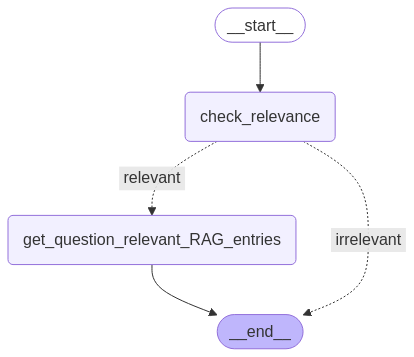

In [19]:

display(Image(dataset.rag_app.get_graph(xray=True).draw_mermaid_png()))

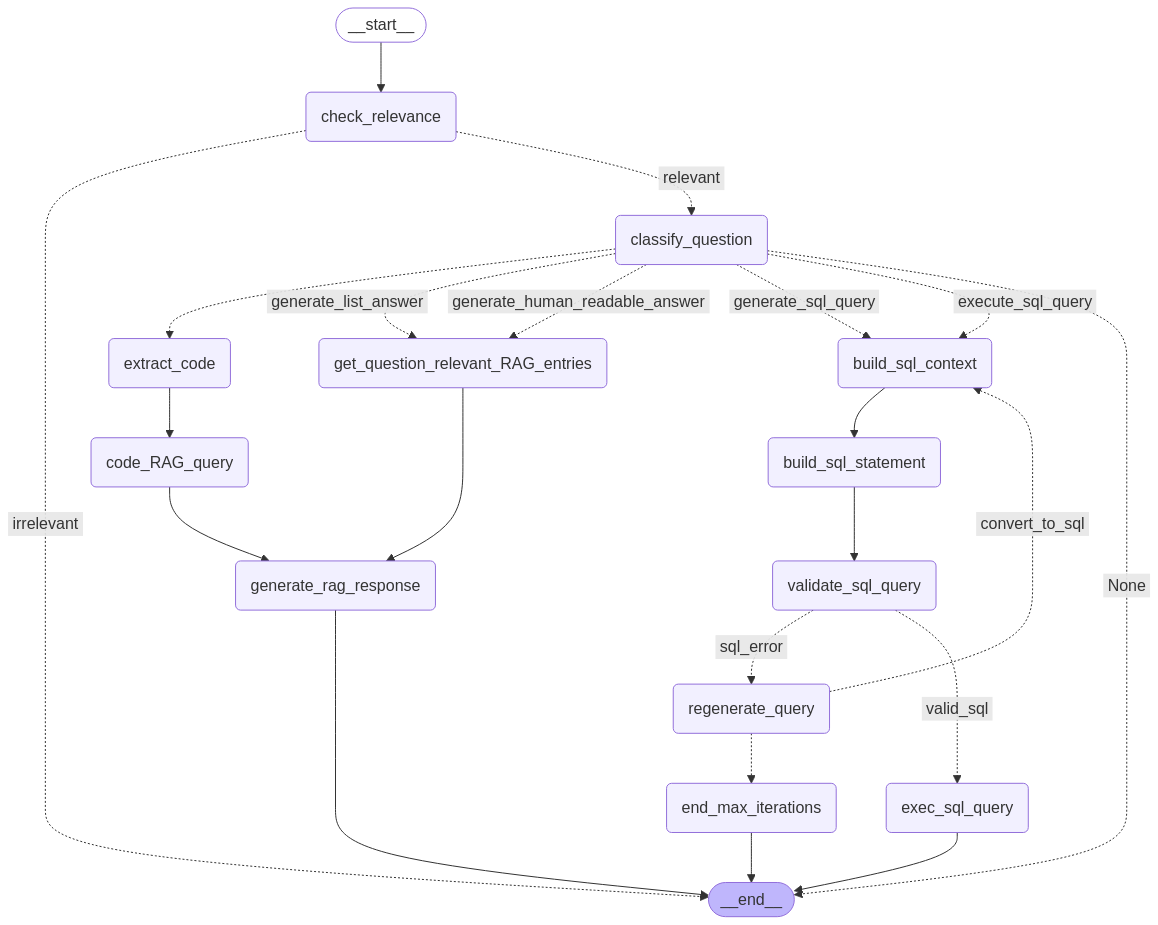

In [20]:
display(Image(dataset.nlq_app.get_graph(xray=True).draw_mermaid_png()))